# Prediction of Churning Credit Card Customers

### Problem: 
A business manager of a consumer credit card portfolio is facing the problem of customer attrition. They want to analyze the data to find out the reason behind this and leverage the same to predict customers who are likely to drop off.

### Solution:
We could construct a model to predict which customer might be churned and the manager could proactively provide them better services and turn customers' decisions in the opposite direction.

Dataset source : https://zenodo.org/record/4322342#.Y-TDWHZBzIX                                                                 
referenced by : https://www.kaggle.com/code/mzmdgaming/credit-card-customer-churn-model

In [435]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay

In [436]:
# Import data locally
df = pd.read_csv('BankChurners.csv',header=0)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


# Data Cleaning for Bank Churn Data

In [437]:
# Checking for shape of the dataset
df.shape

(10127, 23)

In [438]:
# Rename column
df.rename(columns = {'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1': 'Naive_Bayes_Classifier month 1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2': 'Naive_Bayes_Classifier month 2'}, inplace=True)
# Drop columns
df.drop(['CLIENTNUM','Naive_Bayes_Classifier month 1','Naive_Bayes_Classifier month 2'], axis=1, inplace=True)
# View first few rows of the dataframe
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Identifying Missing data ( NaN)

In [439]:
# Identify missing data by summing len(missing values)
df.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

# Investigating unique values for Categorical Variables

 ### Categorical variables: 
 1. Attrition_Flag (Existing Customer, Attrited Customer)
 2. Gender (M, F)
 3. Education_Level (High School, Graduate, Uneducated, College, Post-Graduate, Doctorate)
 4. Marital_Status (Married, Single, Divorced)
 5. Card_Category ('Blue, Gold, Silver, Platinum)

In [440]:
# Loop through the columns of the dataframe for unique values
cat_var = ['Attrition_Flag','Gender','Education_Level','Marital_Status', 'Income_Category', 'Card_Category']
for col in cat_var:
    print("Unique values in column '{}': {}".format(col, df[col].unique()))

Unique values in column 'Attrition_Flag': ['Existing Customer' 'Attrited Customer']
Unique values in column 'Gender': ['M' 'F']
Unique values in column 'Education_Level': ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
Unique values in column 'Marital_Status': ['Married' 'Single' 'Unknown' 'Divorced']
Unique values in column 'Income_Category': ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
Unique values in column 'Card_Category': ['Blue' 'Gold' 'Silver' 'Platinum']


#### We can observe there is an "unknown" type in the dataset. Instead of no input at all NaN values are labeled as  "unkown"  string type.

We will investigate to see whether omitting these values, ie treating them as 'Not Available' will significantly impact our study.

#### We can also observe that "Graduate" and "College" may be classified as one feature.

We will investigate further to know how to go about it

In [441]:
# Get number of rows with unknown values for Education_Level & Marital_Status
unknown_rows = len(df.loc[(df['Education_Level'] == 'Unknown')|(df['Marital_Status'] == 'Unknown')|(df['Income_Category'] == 'Unknown')])

In [442]:
# View unknown values
df.applymap(lambda x: str(x).lower()).applymap(lambda x: str(x) == 'unknown').sum()

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [443]:
# Percentage of unknown rows from total rows in dataset
percentage_unknown = unknown_rows/len(df)
print("Percentage of unknown rows is {:.2f}%".format(percentage_unknown*100))

Percentage of unknown rows is 30.08%


The percentage of our dataset that will be omitted would be 30.08% of the original dataset. This will significantly impact our study if ommited so we will not omit them. On the bright side we still have the values for the sample's respective categorical features.

## Investigating the Target column entries for our model 

In [444]:
# View Number of Existing Customers
#df.applymap(lambda x: str(x)).applymap(lambda x: str(x) == 'Existing Customer').sum()
existing_customer_count = (df['Attrition_Flag'] == 'Existing Customer').sum()
existing_customer_count

8500

In [445]:
# View Attrited Customers
#df.applymap(lambda x: str(x)).applymap(lambda x: str(x) == 'Attrited Customer').sum()
attrited_customer_count = (df['Attrition_Flag'] == 'Attrited Customer').sum()
attrited_customer_count

1627

The number of Existing Customers in our dataset is 8500 while the count for Attrited Customers is only 1627. This disparity can not be ignored while we sample data for building our model. We must reduce the bias in our sample.

## Further Investigation into Features 

In [447]:
# View Number of College
df.applymap(lambda x: str(x)).applymap(lambda x: str(x) == 'College').sum()
college_customer_count = (df['Education_Level'] == 'College').sum()
college_customer_count

1013

In [448]:
# View Number of Graduate
#df.applymap(lambda x: str(x)).applymap(lambda x: str(x) == 'Graduate').sum()
graduate_customer_count = (df['Education_Level'] == 'Graduate').sum()
graduate_customer_count

3128

Since the count of 'College' is 1013 which is significantly less than the count of 'Graduate' which is 3128.

We can choose to replace 'College' with 'Graduate'

In [449]:
# replace all instances of "Graduate" with "College"
df['Education_Level'] = df['Education_Level'].replace("College", "Graduate")

print(df['Education_Level'].unique())

['High School' 'Graduate' 'Uneducated' 'Unknown' 'Post-Graduate'
 'Doctorate']


## Further Investigation into Attrited Customer

In [450]:
df_missing = df.loc[(df['Education_Level'] == 'Unknown') | (df['Marital_Status'] == 'Unknown') | (df['Income_Category'] == 'Unknown')].copy()
#df_missing.applymap(lambda x: str(x)).applymap(lambda x: str(x) == 'Attrited Customer').sum()
attrited_customer_count = (df_missing['Attrition_Flag'] == 'Attrited Customer').sum()
attrited_customer_count

514

For all samples that have unknown features 514 are Attrited Customers,

which is (514/1627)(31.59%) of the total Attrited Customers in the original dataset.

This may or may not affect our model. These features(Marital_Status,etc) may not be significant predictors for our model.

# Bootstrapping to Create a more Representative Population

In [416]:

# Separate the data into two groups, "Existing Customer" and "Attrited Customer"
existing_customers = df[df['Attrition_Flag'] == 'Existing Customer'].copy()
attrited_customers = df[df['Attrition_Flag'] == 'Attrited Customer'].copy()

# Generate 1500 bootstrapped samples from each group
existing_customers_samples = existing_customers.sample(n=1500, replace=True)
attrited_customers_samples = attrited_customers.sample(n=1500, replace=True)

bootstrapped_df = pd.concat([existing_customers_samples, attrited_customers_samples])
print(bootstrapped_df.shape)
bootstrapped_df.head()

(3000, 20)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
7430,Existing Customer,51,M,2,Graduate,Married,$120K +,Blue,43,5,2,3,5232.0,1923,3309.0,0.629,4976,93,0.661,0.368
2479,Existing Customer,55,F,3,Uneducated,Divorced,Less than $40K,Blue,36,3,2,1,2111.0,1209,902.0,0.594,2803,61,0.605,0.573
6092,Existing Customer,58,M,2,High School,Single,$60K - $80K,Silver,49,4,3,3,30186.0,0,30186.0,0.606,4070,74,0.574,0.000
2397,Existing Customer,35,F,3,High School,Married,Less than $40K,Blue,23,3,3,4,3073.0,526,2547.0,0.702,1944,55,0.618,0.171
5245,Existing Customer,54,F,1,High School,Married,Less than $40K,Blue,42,3,5,4,2474.0,1539,935.0,0.649,4884,80,0.509,0.622


# Verifying Our Present Data

In [352]:
# Verifying Count of Attrited Customers for the present data
attrited_customer_count = (bootstrapped_df['Attrition_Flag'] == 'Attrited Customer').sum()
attrited_customer_count

1500

In [353]:
# Verifying Count of Existing Customers for the present data
#bootstrapped_df.applymap(lambda x: str(x)).applymap(lambda x: str(x) == 'Existing Customer').sum()
existing_customer_count = (bootstrapped_df['Attrition_Flag'] == 'Existing Customer').sum()
existing_customer_count

1500

In [354]:
# Validating the categorical features in present data
for col in cat_var:
    print("Unique values in column '{}': {}".format(col, bootstrapped_df[col].unique()))

Unique values in column 'Attrition_Flag': ['Existing Customer' 'Attrited Customer']
Unique values in column 'Gender': ['M' 'F']
Unique values in column 'Education_Level': ['Graduate' 'Uneducated' 'Unknown' 'High School' 'Doctorate'
 'Post-Graduate']
Unique values in column 'Marital_Status': ['Single' 'Married' 'Divorced' 'Unknown']
Unique values in column 'Income_Category': ['$80K - $120K' '$60K - $80K' 'Unknown' 'Less than $40K' '$120K +'
 '$40K - $60K']
Unique values in column 'Card_Category': ['Silver' 'Blue' 'Platinum' 'Gold']


## Description of the Present Data

In [356]:
bootstrapped_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Customer_Age,3000.0,46.404333,7.840408,26.0,41.00000,46.000,52.00000,68.000
Dependent_count,3000.0,2.386667,1.313671,0.0,1.00000,2.000,3.00000,5.000
Months_on_book,3000.0,35.935333,7.914588,13.0,32.00000,36.000,40.00000,56.000
Total_Relationship_Count,3000.0,3.591667,1.602431,1.0,2.00000,3.000,5.00000,6.000
Months_Inactive_12_mon,3000.0,2.495667,0.968311,0.0,2.00000,3.000,3.00000,6.000
Contacts_Count_12_mon,3000.0,2.685667,1.150059,0.0,2.00000,3.000,3.00000,6.000
Credit_Limit,3000.0,8311.866533,8848.304579,1438.3,2391.50000,4413.000,10879.75000,34516.000
Total_Revolving_Bal,3000.0,946.533667,887.081798,0.0,0.00000,900.000,1682.00000,2517.000
Avg_Open_To_Buy,3000.0,7365.332867,8876.824195,3.0,1438.30000,3446.500,9995.00000,34516.000
Total_Amt_Chng_Q4_Q1,3000.0,0.734382,0.230241,0.0,0.60175,0.725,0.86000,3.355


## Visualization of Numeric Features in Present Data

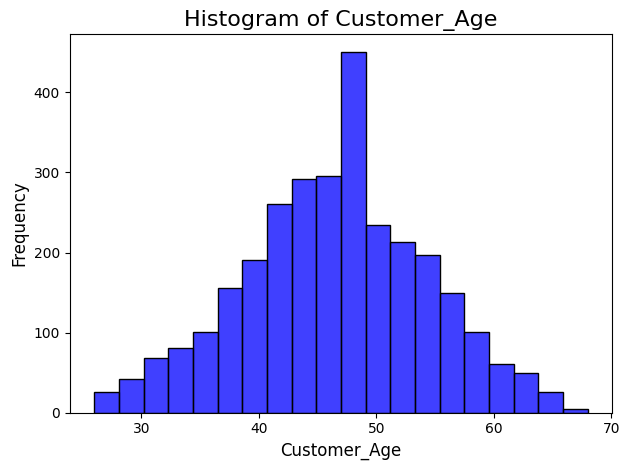

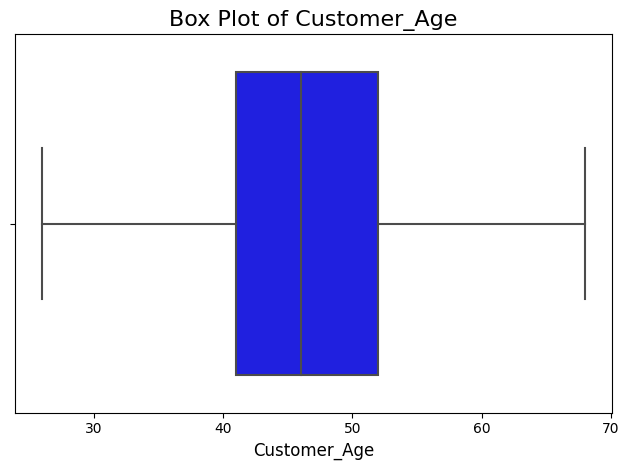

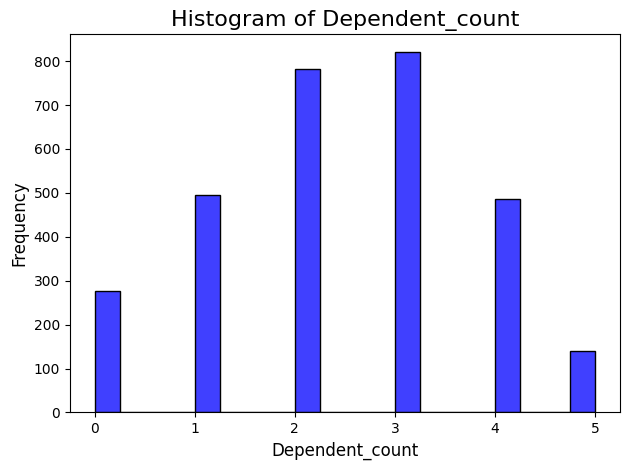

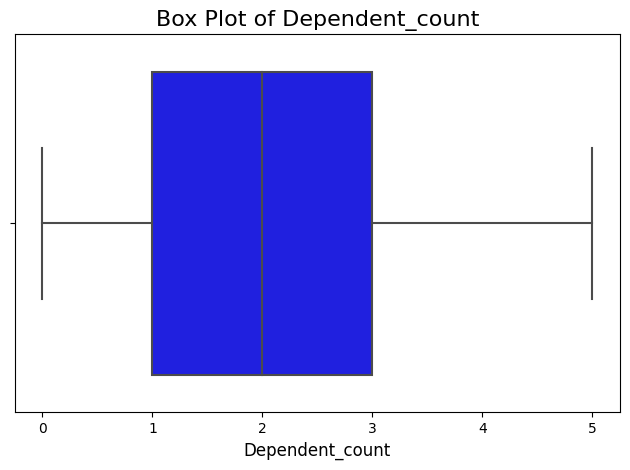

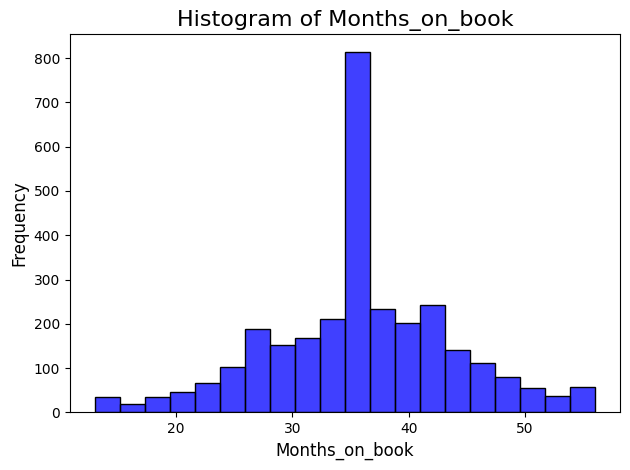

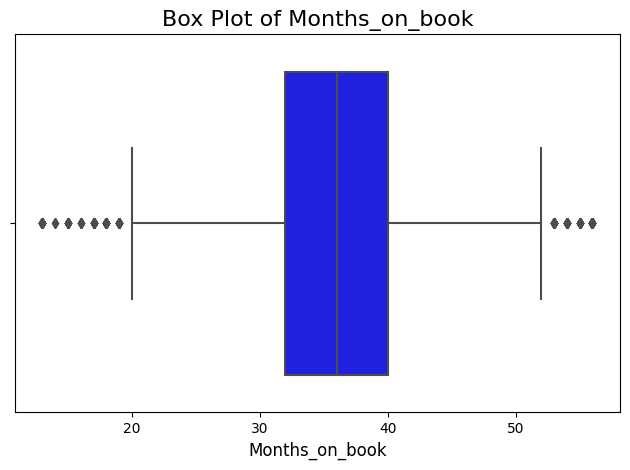

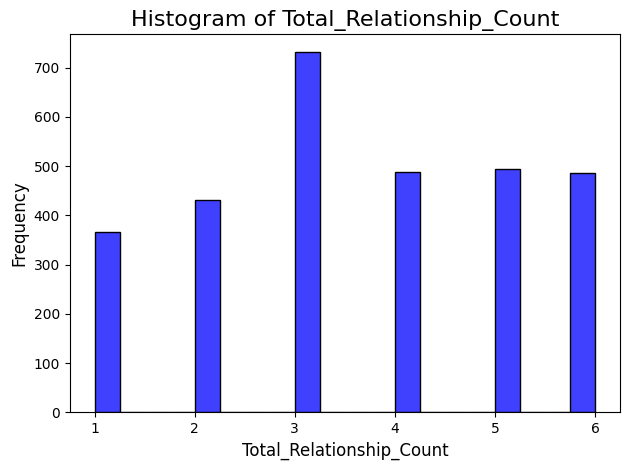

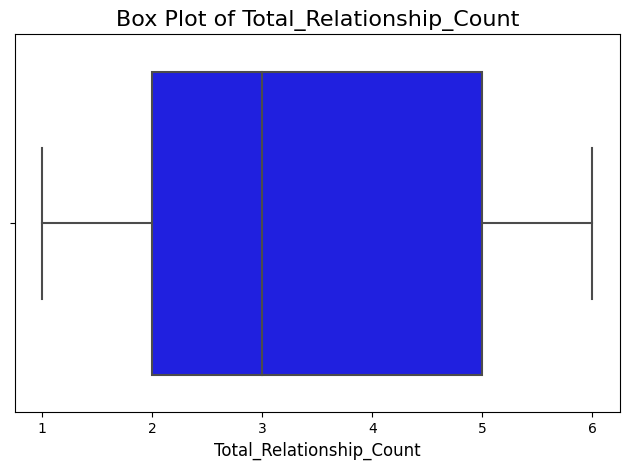

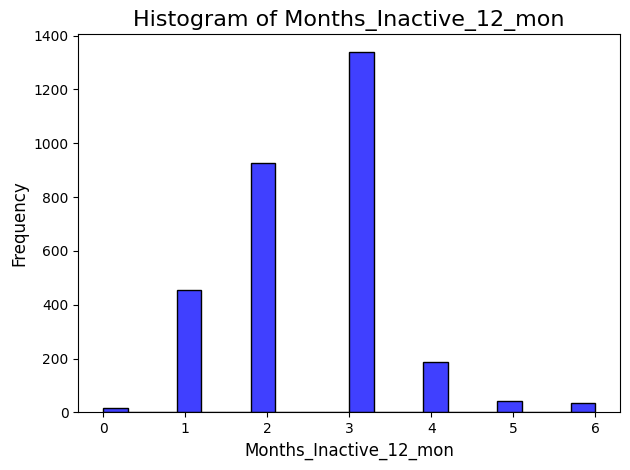

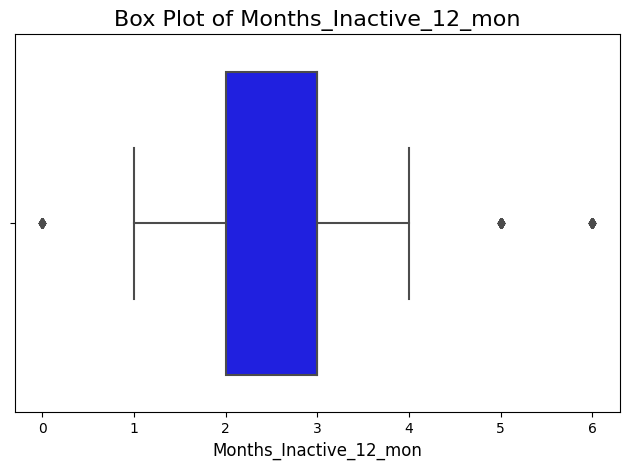

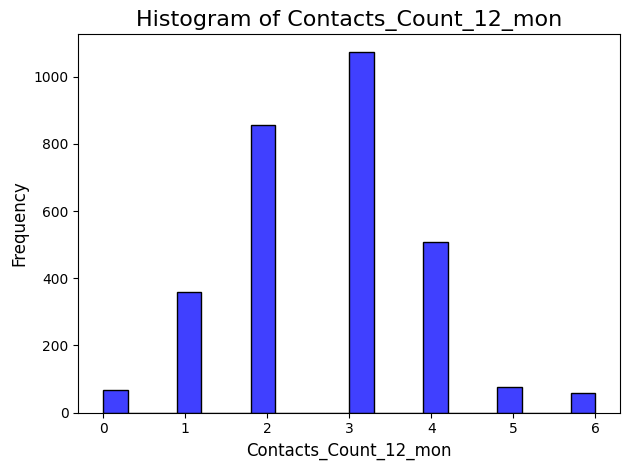

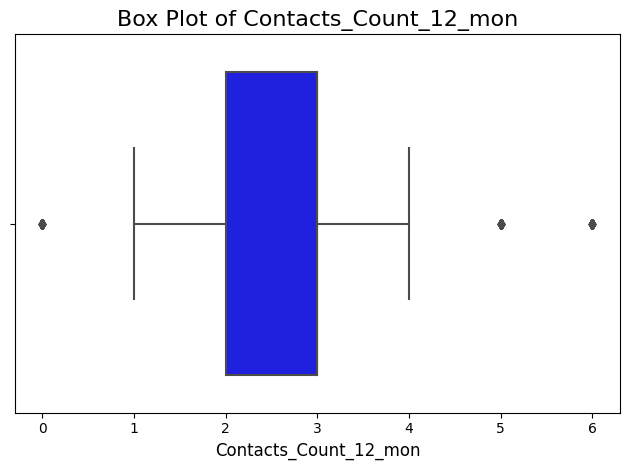

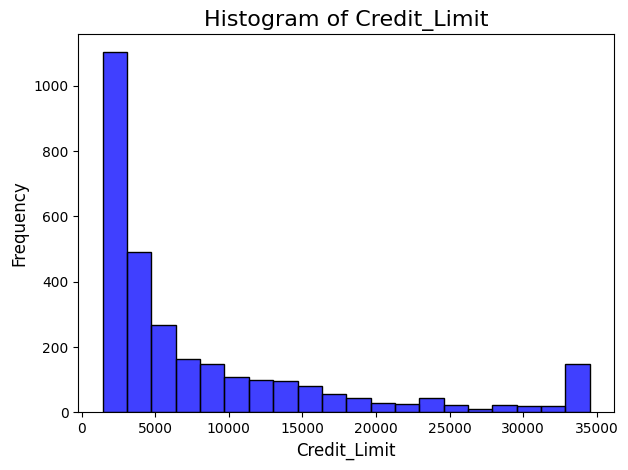

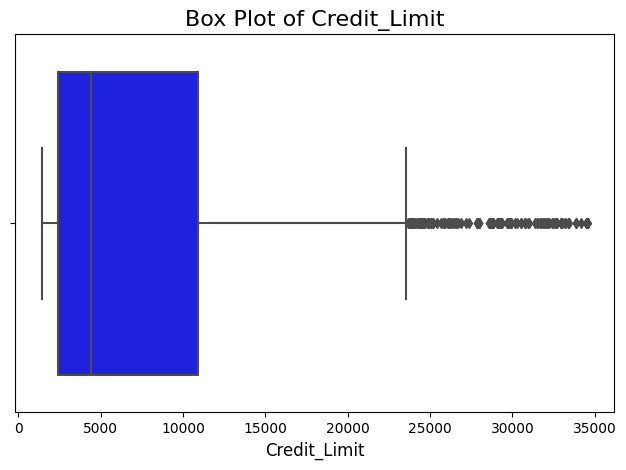

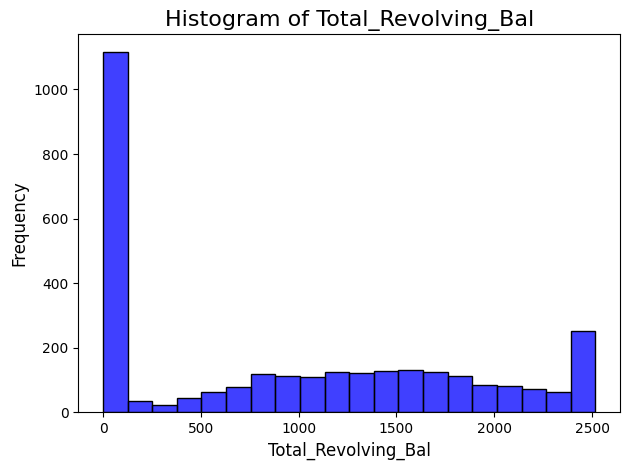

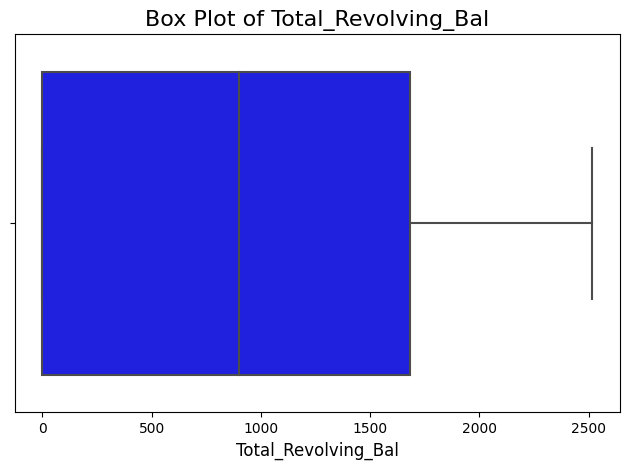

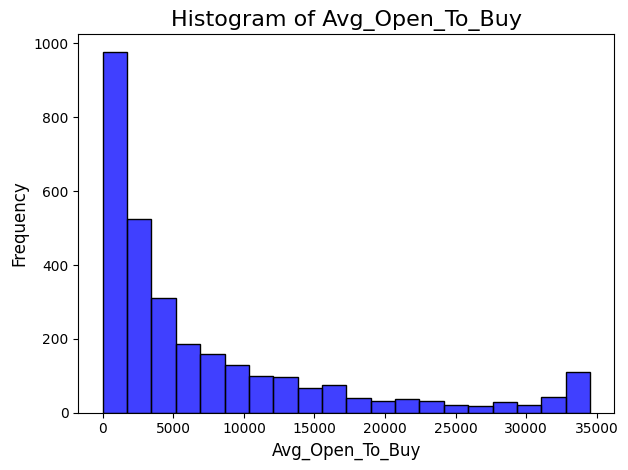

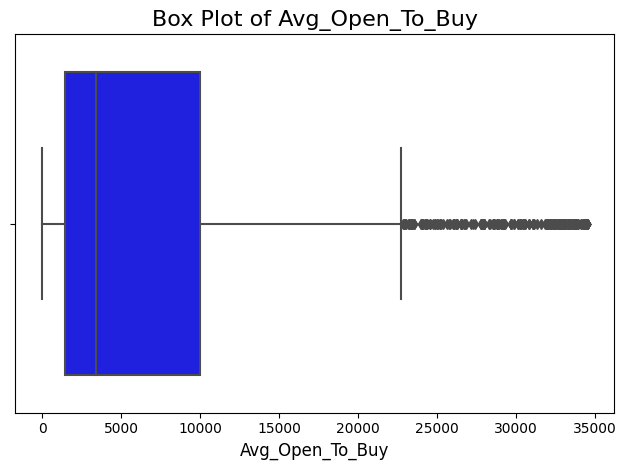

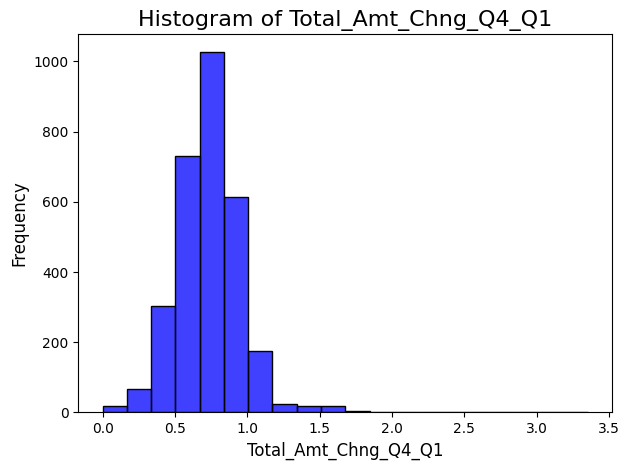

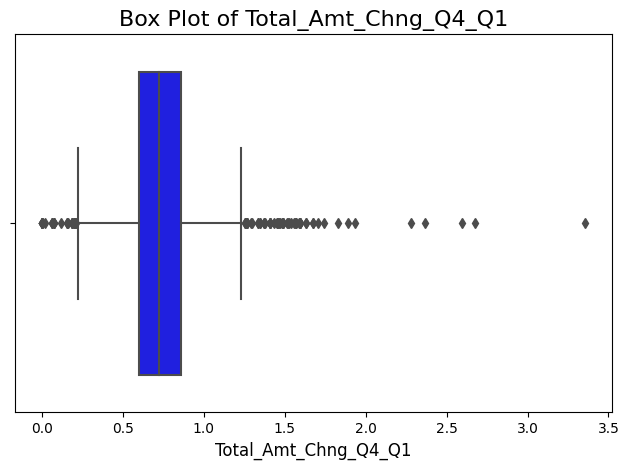

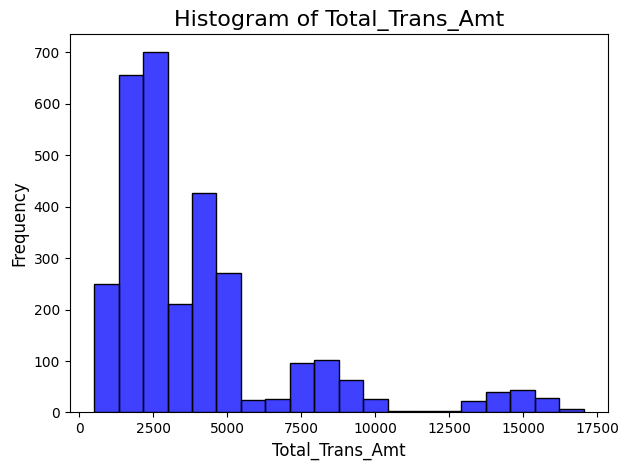

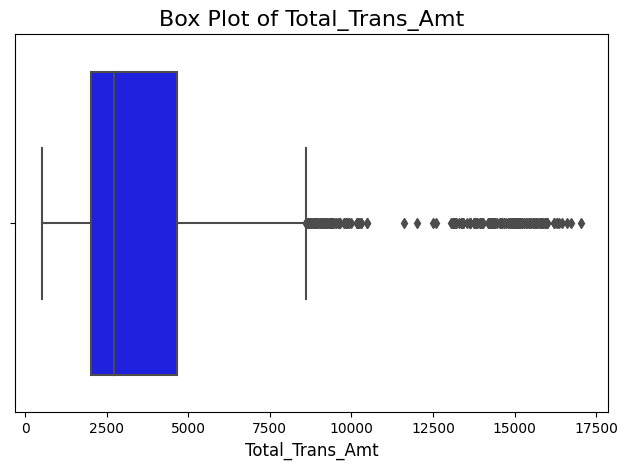

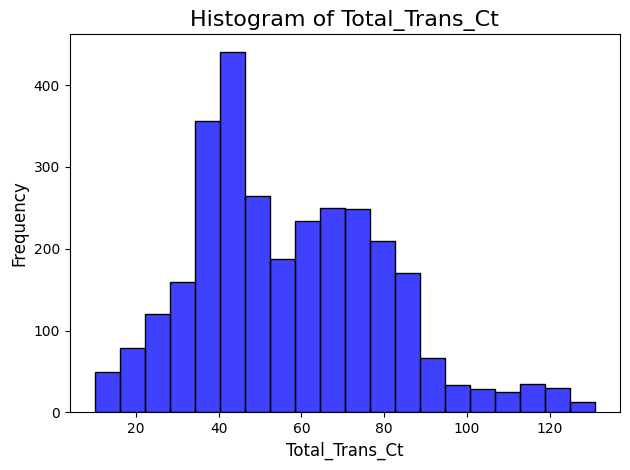

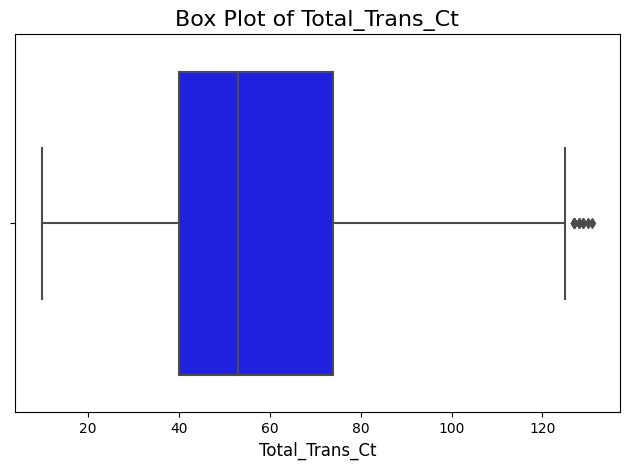

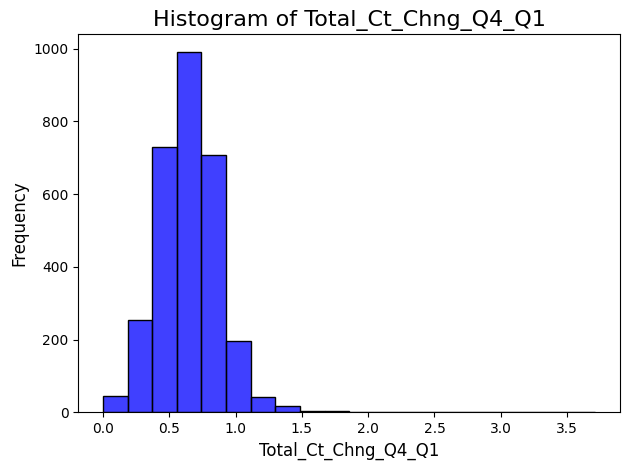

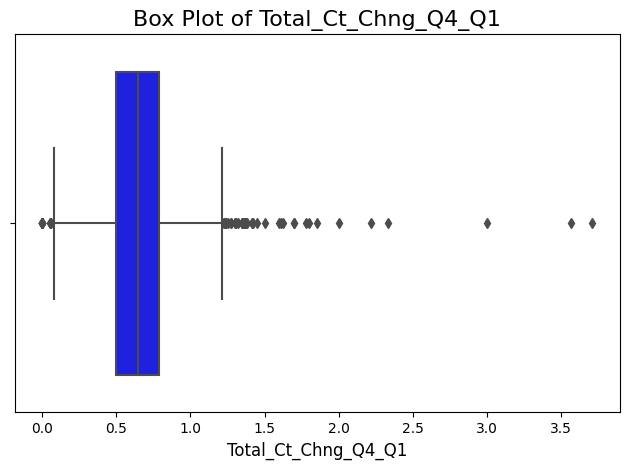

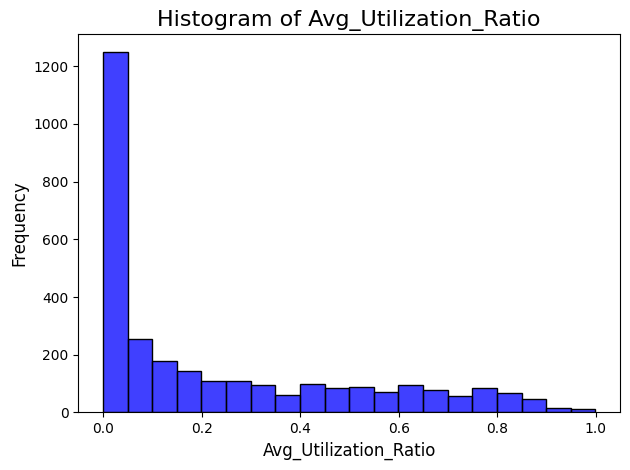

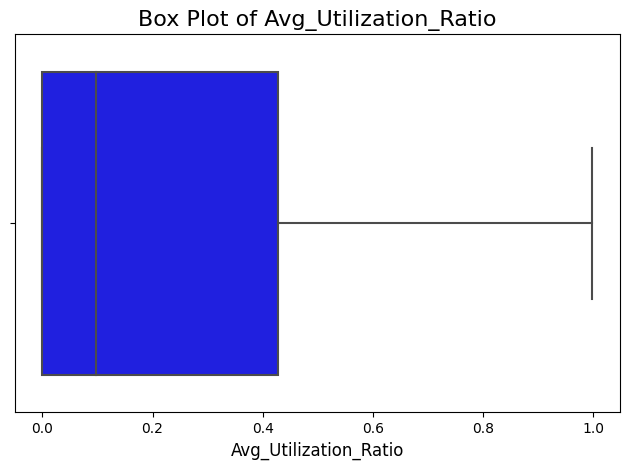

In [357]:
# Select only numeric columns from df_no_missing
numeric_df = bootstrapped_df.select_dtypes(include=['float64', 'int64'])

# Loop over all numeric columns in df_no_missing
for col in numeric_df:
    # Histogram of the column
    sns.histplot(bootstrapped_df[col], kde=False, bins=20, color='blue', edgecolor='black')
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Histogram of {}".format(col), fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Box plot of the column
    sns.boxplot(x=bootstrapped_df[col], color='blue')
    plt.title("Box Plot of {}".format(col), fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.tight_layout()
    plt.show()

## Visualization of Categorical Features in Cleaned Data

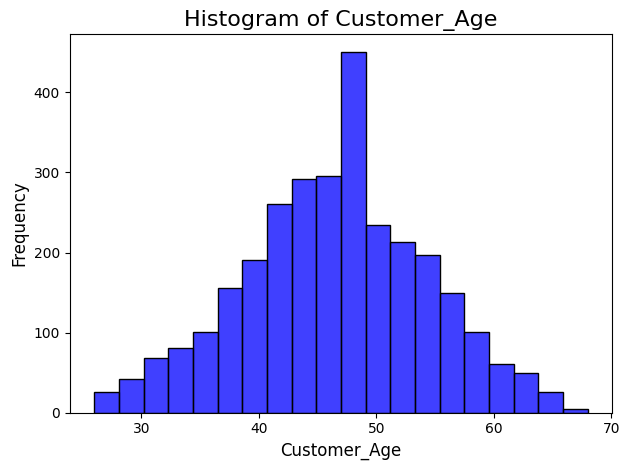

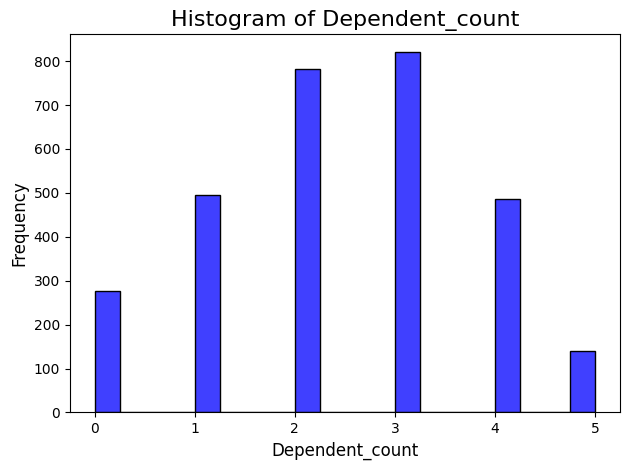

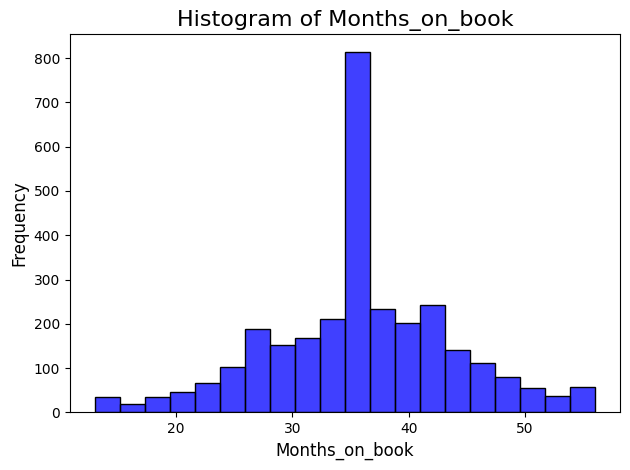

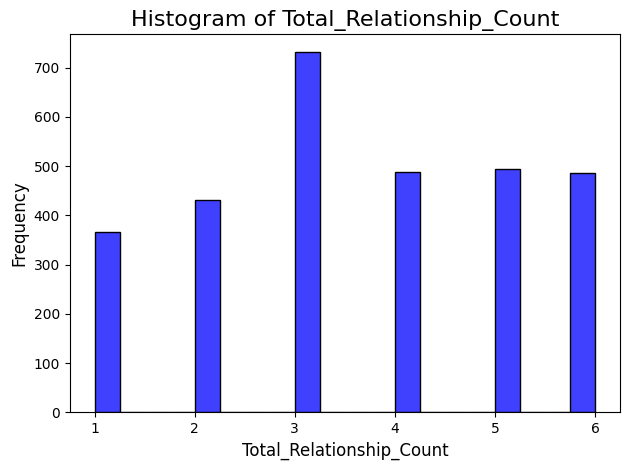

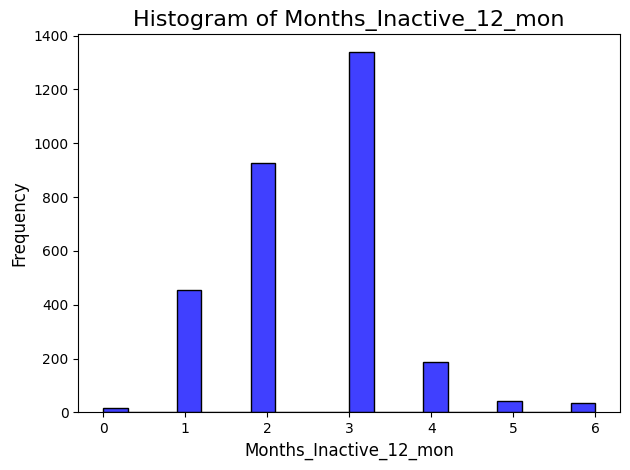

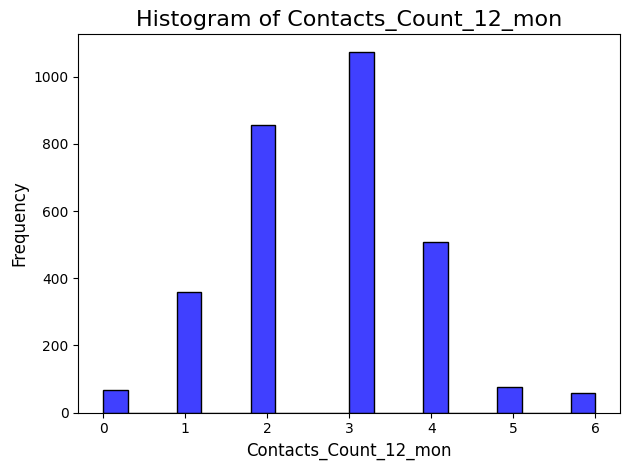

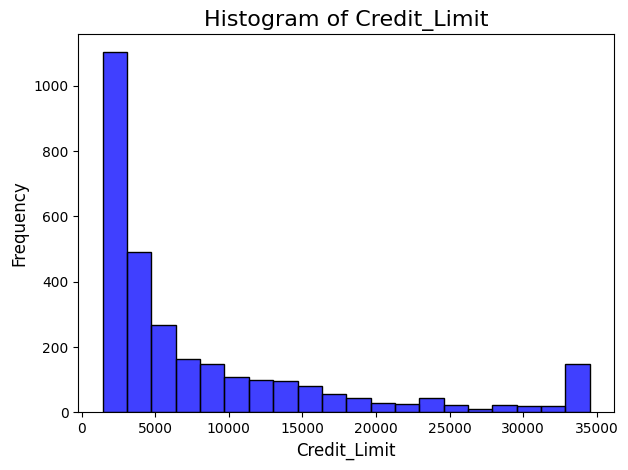

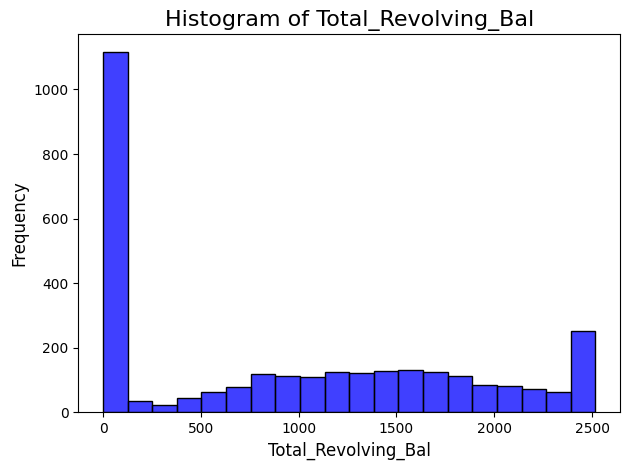

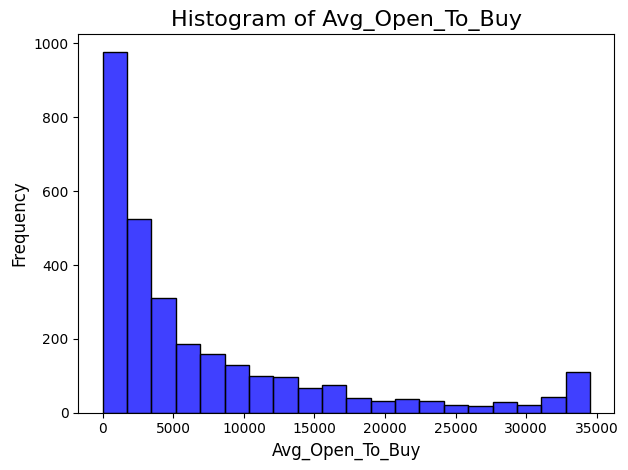

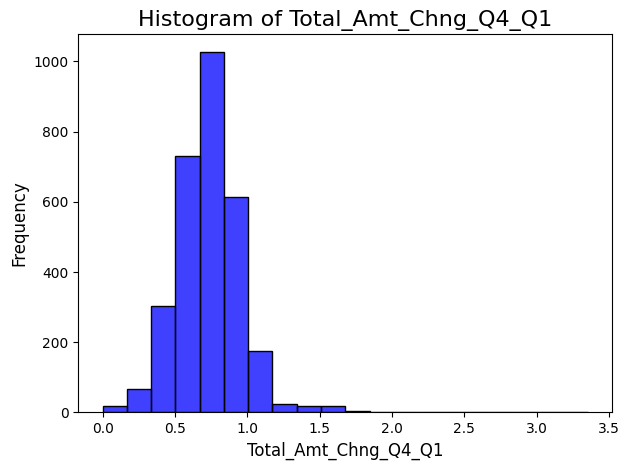

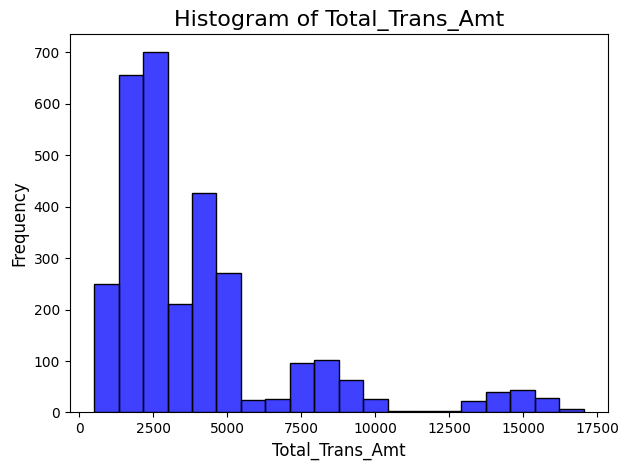

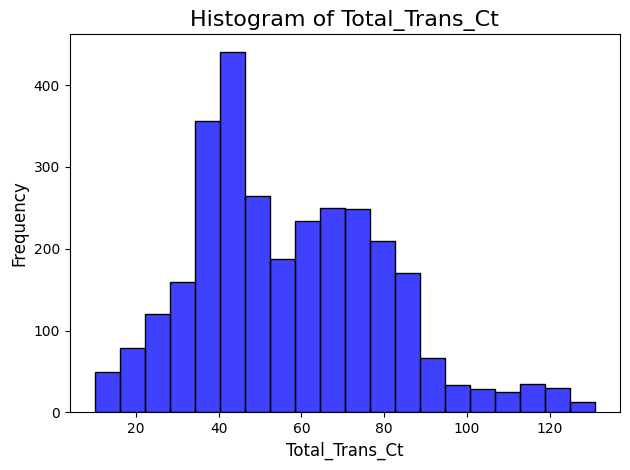

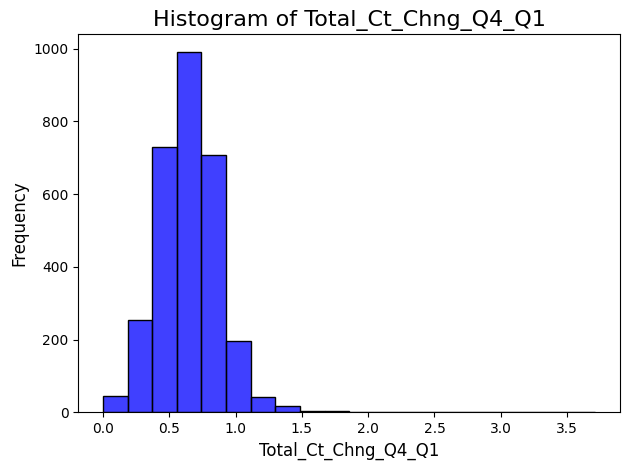

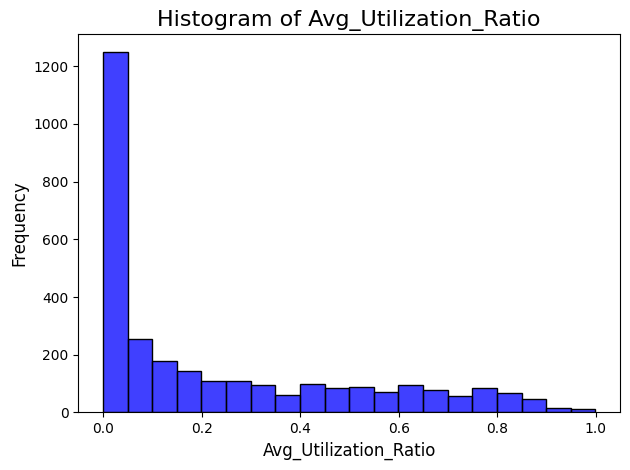

In [358]:
# Select only categorical columns from df_no_missing
category_df = bootstrapped_df.select_dtypes(include=['float64', 'int64'])

# Loop over all numeric columns in df_no_missing
for col in category_df:
    # Histogram of the column
    sns.histplot(bootstrapped_df[col], kde=False, bins=20, color='blue', edgecolor='black')
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Histogram of {}".format(col), fontsize=16)
    plt.tight_layout()
    plt.show()

##  Exploring some Features of our Data

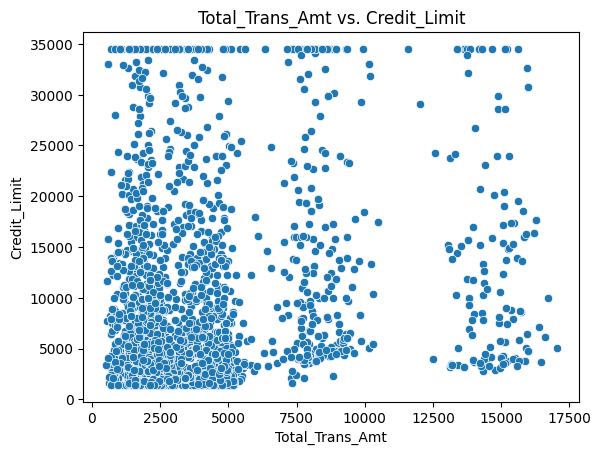

In [360]:
# Plotting Total Revolving Balance vs. Average Open To Buy
sns.scatterplot(x='Total_Trans_Amt', y='Credit_Limit', data=bootstrapped_df)
plt.xlabel('Total_Trans_Amt')
plt.ylabel('Credit_Limit')
plt.title('Total_Trans_Amt vs. Credit_Limit')
plt.show()

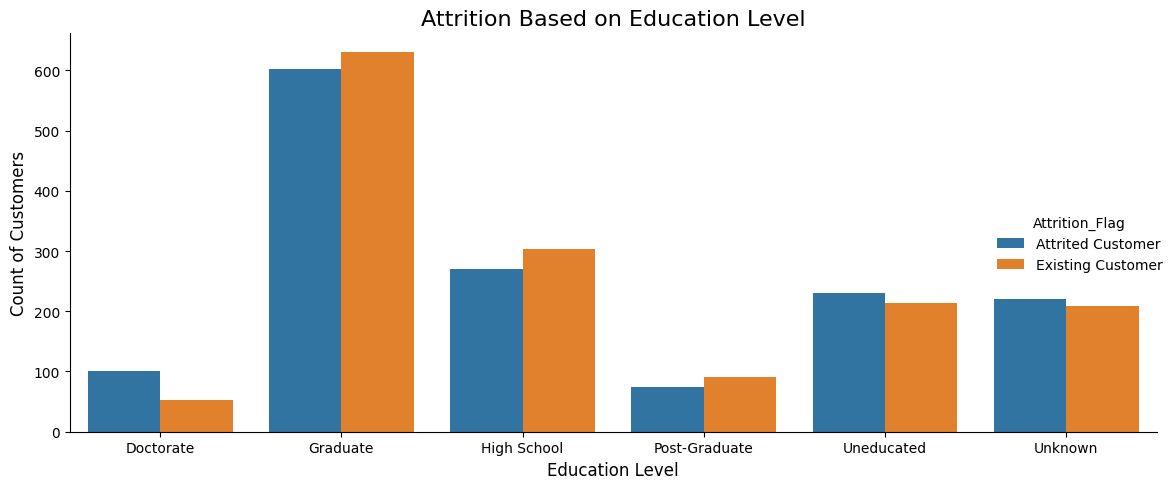

In [361]:
#Group the data by Education_Level and Attrition_Flag and calculate the count of customers in each group
grouped = bootstrapped_df.groupby(['Education_Level', 'Attrition_Flag']).size().reset_index(name='counts')

#Plot the data as a stacked bar chart
sns.catplot(x='Education_Level', y='counts', hue='Attrition_Flag', kind='bar', data=grouped, height=5, aspect=2)
plt.title('Attrition Based on Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Count of Customers', fontsize=12)
plt.tight_layout()
plt.show()


# Hypothesis Testing

The results from the chi-square test between column feature and Attrition_Flag are indicating the association or dependence between these two categorical variables. 

The p-value represents the probability of observing the calculated chi-square statistic or any value more extreme under the assumption of independence.

The results from the t-test between column feature and Attrition_Flag are indicating the association or dependence between the numeric feature and Attrition_Flag

## Independence Test for Features in Present Data

### For Categorical Features

In [417]:

alpha = 0.05

# Perform chi-square test for categorical variables
for col in category_df:
    crosstab = pd.crosstab(bootstrapped_df[col], bootstrapped_df['Attrition_Flag'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    if p > alpha:
        print(f"Chi-Square test between {col} and Attrition_Flag:")
        print(f"Chi-Square statistic: {chi2}")
        print(f"p-value: {p}")
        print("There is not enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent\n")



### For Numeric Features

In [418]:
# Perform t-test for numerical variables
for col in numeric_df:
    attrition_yes = bootstrapped_df[bootstrapped_df['Attrition_Flag'] == 'Existing Customer'][col]
    attrition_no = bootstrapped_df[bootstrapped_df['Attrition_Flag'] == 'Attrited Customer'][col]
    t_stat, p = stats.ttest_ind(attrition_yes, attrition_no)
    if p > alpha:
        print(f"t-test between {col} and Attrition_Flag:")
        print(f"t-statistic: {t_stat}")
        print(f"p-value: {p}")
        print("There is not enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent\n")

t-test between Customer_Age and Attrition_Flag:
t-statistic: -1.7000696970266216
p-value: 0.08922154030064895
There is not enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent

t-test between Months_on_book and Attrition_Flag:
t-statistic: -1.2935354513600212
p-value: 0.19592558332436974
There is not enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent

t-test between Avg_Open_To_Buy and Attrition_Flag:
t-statistic: 0.24893732753529502
p-value: 0.8034263127647935
There is not enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent



## Test for Dependent Features in Present Data

### For Categorical Features

In [419]:

alpha = 0.05

# Perform chi-square test for categorical variables
for col in category_df:
    crosstab = pd.crosstab(bootstrapped_df[col], bootstrapped_df['Attrition_Flag'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    if p < alpha:
        print(f"Chi-Square test between {col} and Attrition_Flag:")
        print(f"Chi-Square statistic: {chi2}")
        print(f"p-value: {p}")
        print("There is enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent\n")


Chi-Square test between Customer_Age and Attrition_Flag:
Chi-Square statistic: 79.97372094762083
p-value: 0.0002581638055193561
There is enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent

Chi-Square test between Dependent_count and Attrition_Flag:
Chi-Square statistic: 13.760887602943546
p-value: 0.01720179610899447
There is enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent

Chi-Square test between Months_on_book and Attrition_Flag:
Chi-Square statistic: 69.48061812779106
p-value: 0.006442358523467004
There is enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent

Chi-Square test between Total_Relationship_Count and Attrition_Flag:
Chi-Square statistic: 191.49152791986123
p-value: 1.874874167425226e-39
There is enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent

Chi-Square test between Months_Inact

### For Numeric Features

In [420]:
# Perform t-test for numerical variables
for col in numeric_df:
    attrition_yes = bootstrapped_df[bootstrapped_df['Attrition_Flag'] == 'Existing Customer'][col]
    attrition_no = bootstrapped_df[bootstrapped_df['Attrition_Flag'] == 'Attrited Customer'][col]
    t_stat, p = stats.ttest_ind(attrition_yes, attrition_no)
    if p < alpha:
        print(f"t-test between {col} and Attrition_Flag:")
        print(f"t-statistic: {t_stat}")
        print(f"p-value: {p}")
        print("There is enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent\n")

t-test between Dependent_count and Attrition_Flag:
t-statistic: -2.9700945395898257
p-value: 0.003000704394329702
There is enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent

t-test between Total_Relationship_Count and Attrition_Flag:
t-statistic: 12.342743020298887
p-value: 3.5530062907777095e-34
There is enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent

t-test between Months_Inactive_12_mon and Attrition_Flag:
t-statistic: -11.158176759476728
p-value: 2.3450246861382886e-28
There is enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent

t-test between Contacts_Count_12_mon and Attrition_Flag:
t-statistic: -15.894835573900064
p-value: 1.1082091846577708e-54
There is enough evidence to reject the null hypothesis that the variable and Attrition_Flag are independent

t-test between Credit_Limit and Attrition_Flag:
t-statistic: 1.9831313874271446
p

## Processing Data for Feature Engineering

In [424]:
# Assign binary values once and then comment code.(one time code)
#bootstrapped_df['Attrition_Flag'] = bootstrapped_df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
print(bootstrapped_df['Attrition_Flag'].isnull().sum())

# Defining y for our model building
y = bootstrapped_df['Attrition_Flag']
print(y.shape, y.dtype)

0
(3000,) int64


# Pre-processing present data for PCA (Principal Component Analysis)

We first of all drop the column we want our model to predict. This column is dropped before we begin to encode and scale our data.

If 'Attrition_Flag', the target variable, isn't dropped, then one-hot encoding would create separate columns for each possible value of the variable, making it difficult to model the target variable as it would introduce multicollinearity.

##### In the event we do not drop this column the model would always have a 100% accuracy which would be grossly misleading.

In [425]:
bootstrapped_df = bootstrapped_df.drop(['Attrition_Flag'], axis=1)

# First converting categorical features into numerical values using one-hot encoding
encoder = OneHotEncoder()
categorical_features = ['Gender', 'Education_Level', 'Marital_Status','Income_Category', 'Card_Category']
encoded_df = encoder.fit_transform(bootstrapped_df[categorical_features])
encoded_cols = encoder.get_feature_names_out(categorical_features)

# Scale the numerical features using StandardScaler
scaler = StandardScaler()
numerical_features = bootstrapped_df.drop(categorical_features, axis=1)
scaled_df = scaler.fit_transform(numerical_features)
scaled_cols = numerical_features.columns

# Combine the numerical and encoded features into a single data frame
df_for_pca = pd.concat([pd.DataFrame(scaled_df, columns=scaled_cols), pd.DataFrame(encoded_df.toarray(), columns=encoded_cols)], axis=1)

#y = df_for_pca[['Attrition_Flag_Existing Customer', 'Attrition_Flag_Attrited Customer']]
df_for_pca



,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0.583785,-0.285337,0.882258,0.894332,-0.490008,0.278200,-0.356352,1.062030,-0.457974,-0.481442,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.093937,0.492147,-0.008184,-0.367067,-0.490008,-1.480703,-0.693098,0.263190,-0.717231,-0.643863,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.476552,-0.285337,1.645494,0.263632,0.532262,0.278200,2.336110,-1.089468,2.436932,-0.588176,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.456826,0.492147,-1.661861,-0.367067,0.532262,1.157651,-0.589301,-0.500967,-0.540049,-0.142677,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.966399,-1.062821,0.755052,-0.367067,2.576800,1.157651,-0.653932,0.632402,-0.713676,-0.388630,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.436521,-0.285337,-0.008184,1.525031,-0.490008,1.157651,2.803304,0.563035,2.744227,-1.896829,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2996,0.583785,-0.285337,0.500640,1.525031,0.532262,1.157651,0.042651,1.726611,-0.123644,-0.332942,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2997,-1.074211,-1.840304,-1.789067,-0.367067,-0.490008,2.037103,-0.752981,-1.089468,-0.646789,-0.198365,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2998,-1.456826,-0.285337,-0.008184,0.894332,0.532262,0.278200,-0.712520,-1.089468,-0.606398,0.599821,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Exploring Correlation between Features

A threshold of 0.5 is set to omit features that have insufficient correlation between them(r < 0.5 and r < -0.5).

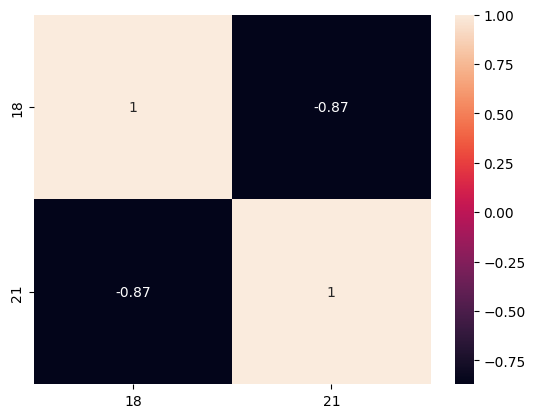

In [428]:

encoded = pd.DataFrame(encoded_df.toarray())
# Calculate the pairwise correlation between columns
correlation = encoded.corr()
# Set the threshold for correlation
threshold = 0.5

# Find columns that have a correlation below the threshold
columns_to_drop = [column for column in correlation.columns if abs(correlation[column].iloc[-1]) < threshold]

# Drop the columns from the DataFrame
encoded = encoded.drop(columns_to_drop, axis=1)
correlation_sig = encoded.corr()

sns.heatmap(correlation_sig, annot=True)
plt.show()

In [429]:
correlation = ["positively correlated", "negatively correlated"]
column_pairs = [[18, 21]]

for pair in column_pairs:
    cols_x = df_for_pca.columns[pair[0]]
    cols_y = df_for_pca.columns[pair[1]]
    print(cols_x + " and " + cols_y + " are " + correlation[(pair[0]+pair[1])%2] + "\n")

Education_Level_High School and Education_Level_Unknown are negatively correlated



This inverse relationship between Education_Level_High School and Education_Level_Unknown can give us an idea of the behavior of the unknown education category since their characteristics can be described as the opposite of what we know for individuals in the high school education category

## Performing PCA on Data

In order to see the amount of total variance explained/attributed to each feature/component, we perform PCA on the data

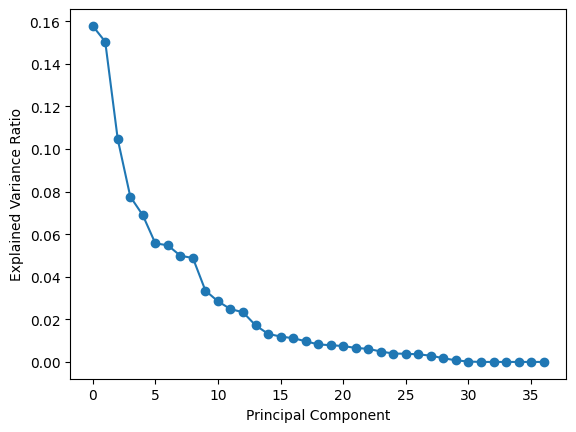

In [370]:
# Perform PCA
pca = PCA()
pca.fit(df_for_pca)

# Get the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Get the principal components
principal_components = pca.components_

# Project the original data onto the first n principal components
n = len(explained_variance_ratio)
projected_data = np.dot(df_for_pca, principal_components[:n, :].T)

# Plot the explained variance ratio
plt.plot(explained_variance_ratio[:n], '-o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

##  Plotting the Cumulative Explained Variance Ratio

In [371]:
# Validating PCA
# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Determine the number of components to keep
threshold = 0.95
num_components = np.argmax(cumulative_explained_variance_ratio >= threshold) + 1
print("Number of components to keep:", num_components)

Number of components to keep: 19


We can use PCA to determine the number of features/components to be kept per the defined threshold.

A threshold of 0.95 or 95% means we want to maintain at least 95% of the cummulative explained variance

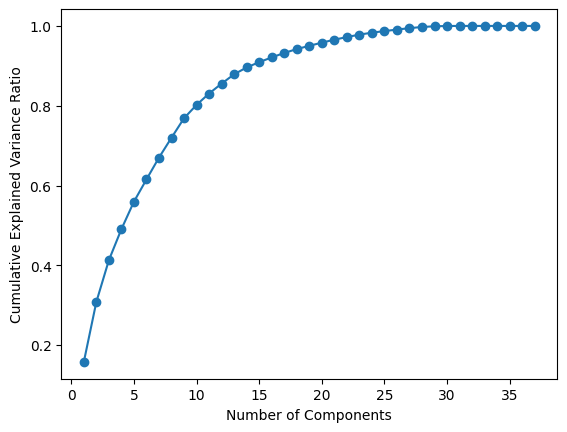

In [372]:
# Plot the cumulative explained variance ratio
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

## Optimizing the Data to Select the most important Features

In [457]:
# Create a Logistic Regression model
model = LogisticRegression()

# Use stratified K-Fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store the performance results
results = []

# Try different values of n_features_to_select
for i in range(1, len(df_for_pca.columns) + 1):
    # Use Recursive Feature Elimination (RFE) to select the most important features
    rfe = RFE(model, n_features_to_select=i)
    score = cross_val_score(rfe, df_for_pca, y, cv=kfold, scoring='accuracy')
    results.append(score.mean())

# Find the value of n_features_to_select that results in the highest accuracy
best_n = results.index(max(results)) + 1

# Use Recursive Feature Elimination (RFE) to select the most important features
rfe = RFE(model, n_features_to_select=best_n )
rfe = rfe.fit(df_for_pca, y)

# Print the selected features
selected_features = df_for_pca.columns[rfe.support_]
print("Selected features: ", selected_features)
print(len(selected_features))

Selected features:  Index(['Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Gender_F', 'Gender_M',
       'Education_Level_Doctorate', 'Education_Level_Post-Graduate',
       'Income_Category_$120K +', 'Income_Category_$80K - $120K',
       'Card_Category_Gold', 'Card_Category_Platinum'],
      dtype='object')
15


We have succesfully used the Recursive Feature Elimination (RFE) to select the most important features.
Now then, We can use only the selected features to train our model.

In [461]:
# Filter the present data for only important features
# This filtered data 'X' will be used to train our models
X = df_for_pca[selected_features]
X

,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Gender_F,Gender_M,Education_Level_Doctorate,Education_Level_Post-Graduate,Income_Category_$120K +,Income_Category_$80K - $120K,Card_Category_Gold,Card_Category_Platinum
0,0.894332,-0.490008,0.278200,1.062030,0.365779,1.600976,0.062561,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.367067,-0.490008,-1.480703,0.263190,-0.355741,0.177715,-0.178744,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.263632,0.532262,0.278200,-1.089468,0.064952,0.755915,-0.312324,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.367067,0.532262,1.157651,-0.500967,-0.640962,-0.089147,-0.122727,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.367067,2.576800,1.157651,0.632402,0.335231,1.022776,-0.592411,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1.525031,-0.490008,1.157651,0.563035,-0.666197,-0.756300,-1.872193,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2996,1.525031,0.532262,1.157651,1.726611,-0.566918,-0.845254,-1.247384,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2997,-0.367067,-0.490008,2.037103,-1.089468,-0.528401,-0.489439,-0.260616,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,0.894332,0.532262,0.278200,-1.089468,-0.462325,-0.756300,-0.200289,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model building and evaluation - Gaussian Naive Bayes classifier

After optimizing the data we observed that most of the significant features are continuous variables. We however make the assumption that these features follow the normal distribution. This seems to be the case for most in our data exploration.

While also assuming the features are independent. This is one of things our optimization hoped to achieve for the data.

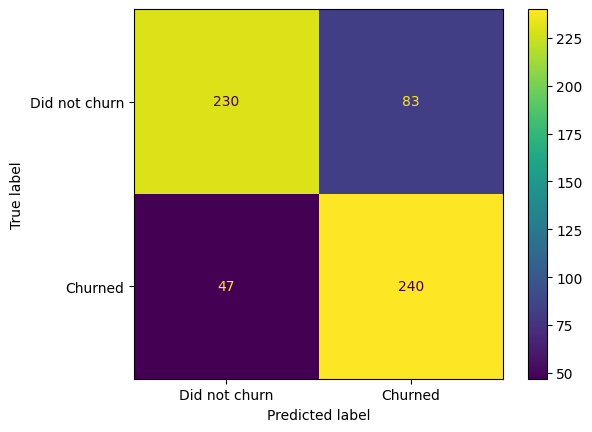

In [459]:
# Split the PCA-reduced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the model
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, gnb.predict(X_test)), display_labels=["Did not churn", "Churned"]).plot()


The Confusion Matrix -- A summary of the models performance shows the matrix of correct and wrong predictions given by the model.

### Evaluating model performance

The accuracy score calculation given by dividing the number of correct predictions by the number of total predictions.

Correct predictions include 'True Positives' and 'True Negatives'

In [460]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 78.33%


## Model building and evaluation - Random Forest Classifier

Random Forest is suitable to situations when we have a large dataset and interpretability is not a major concern.

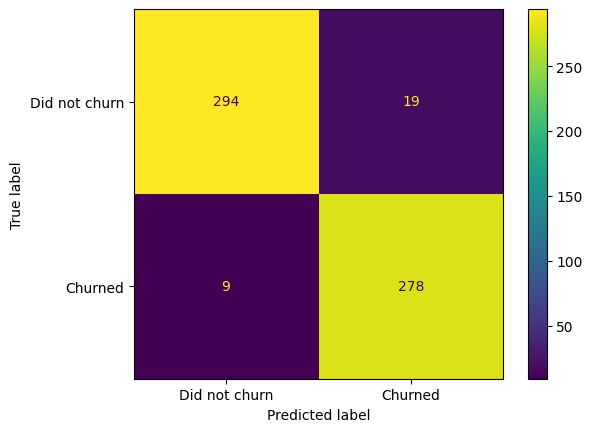

In [463]:

# Split the PCA-reduced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rfc = RandomForestClassifier()

# Train the model
rfc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfc.predict(X_test)

# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, rfc.predict(X_test)), display_labels=["Did not churn", "Churned"]).plot()

The Confusion Matrix -- A summary of the models performance shows the matrix of correct and wrong predictions given by the model.

### Evaluating model performance

The accuracy score calculation given by dividing the number of correct predictions by the number of total predictions.

Correct predictions include 'True Positives' and 'True Negatives'

In [464]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 95.33%


# Conclusion

We have successfully built two models to solve the problem of predicting which customer might churn/attrite, Allowing the manager to proactively provide them better services and turn customers' decisions in the opposite direction.

In scoring the accuracy of the models -- Gaussian Naive Bayes classifier and Random Forest Classifier, we observed that the Random Forest Classifier had greater accuracy in predicting the results in the test data.

Based on our Hypothesis Testing for independence we observe that some features of the data were dependent.
Although we optimized the data, The Random Forest Classifier worked best for our study.




##### Author: Maarouf B. Hatab